In [3]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from utils.plotting import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF
from scipy.sparse import coo_matrix, find


from run_id import run_id
run_id = 662
stat = RunStats.objects.get(pk=run_id)
q = stat.query
print(q.title)

from shapely.geometry import Polygon

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

wos_all_updated


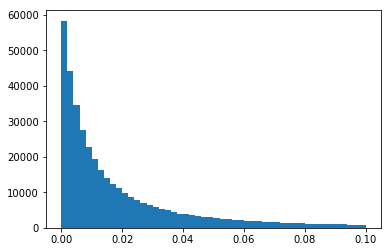

411717

In [4]:
tts = TopicTerm.objects.filter(run_id=run_id)


scores = list(tts.values_list('score',flat=True))

plt.hist([s for s in scores if s < 0.1],bins=50)

plt.show()

tts.count()

In [3]:
column = 'term_id'

if column=='doc_id':
    db_matrix = DocTopic.objects.filter(run_id=run_id,score__gt=0.01)
else:
    db_matrix = TopicTerm.objects.filter(run_id=run_id,score__gt=0.01)


from scipy.sparse import *

vs = list(db_matrix.values('score',column,'topic_id'))

c_ind = np.array(db_matrix.values_list(column,flat=True).order_by(column).distinct())
r_ind = np.array(db_matrix.values_list('topic_id',flat=True).order_by('topic_id').distinct())

d = [x['score'] for x in vs]


c = [int(np.where(c_ind==x[column])[0]) for x in vs]
r = [int(np.where(r_ind==x['topic_id'])[0]) for x in vs]

m = csr_matrix((d,(r,c)),shape=(len(r_ind),len(c_ind)))

print(db_matrix.count())

95076


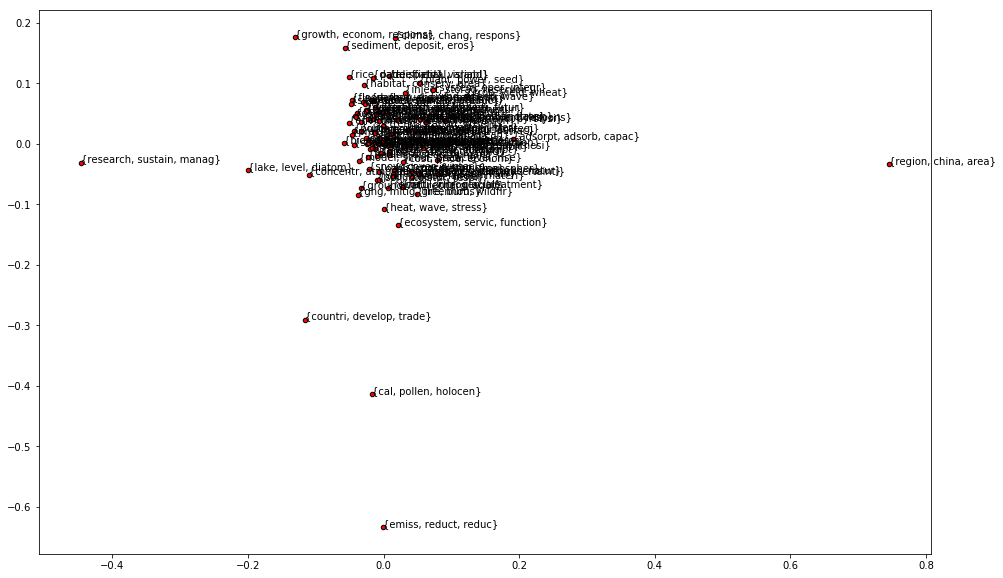

In [4]:
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10, n_components=2)
X_kpca = kpca.fit_transform(m.toarray())
plt.rcParams["figure.figsize"] = [16,10]

plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c="red",
            s=20, edgecolor='k')


for i,t in enumerate(Topic.objects.filter(id__in=r_ind)):
    plt.text(X_kpca[i,0],X_kpca[i,1],t.title)

plt.show()

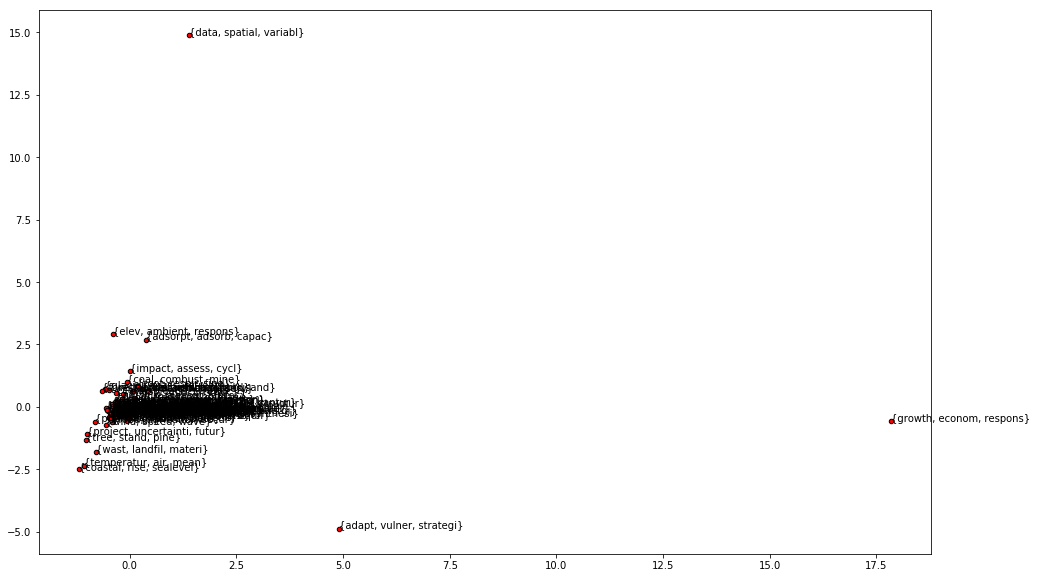

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(m.toarray())


plt.rcParams["figure.figsize"] = [16,10]

plt.scatter(X_pca[:, 0], X_pca[:, 1], c="red",
            s=20, edgecolor='k')


for i,t in enumerate(Topic.objects.filter(id__in=r_ind)):
    plt.text(X_pca[i,0],X_pca[i,1],t.title)

plt.show()

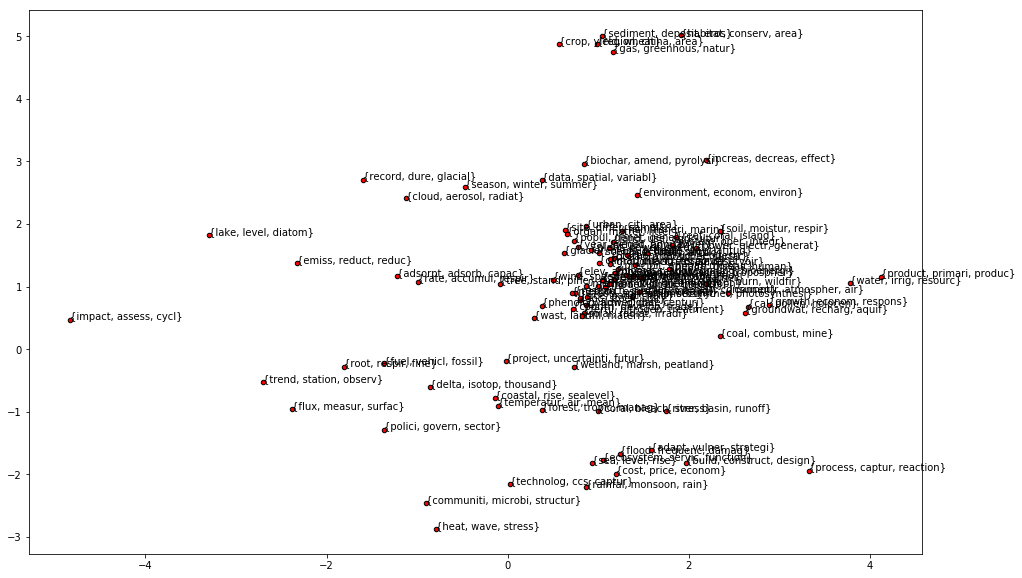

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(m.toarray())

for r,t in enumerate(X_pca):
    for c,v in enumerate(t):
        if v > 0:
            X_pca[r,c] = np.log(v)
        elif v < 0:
            X_pca[r,c] = np.log(abs(v)) * -1

plt.rcParams["figure.figsize"] = [16,10]

plt.scatter(X_pca[:, 0], X_pca[:, 1], c="red",
            s=20, edgecolor='k')


for i,t in enumerate(Topic.objects.filter(id__in=r_ind)):
    plt.text(X_pca[i,0],X_pca[i,1],t.title)

plt.show()

/usr/local/lib/python3.4/dist-packages/scipy/spatial/_plotutils.py:17: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()
/usr/local/lib/python3.4/dist-packages/scipy/spatial/_plotutils.py:19: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(True)
/usr/local/lib/python3.4/dist-packages/scipy/spatial/_plotutils.py:22: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(was_held)


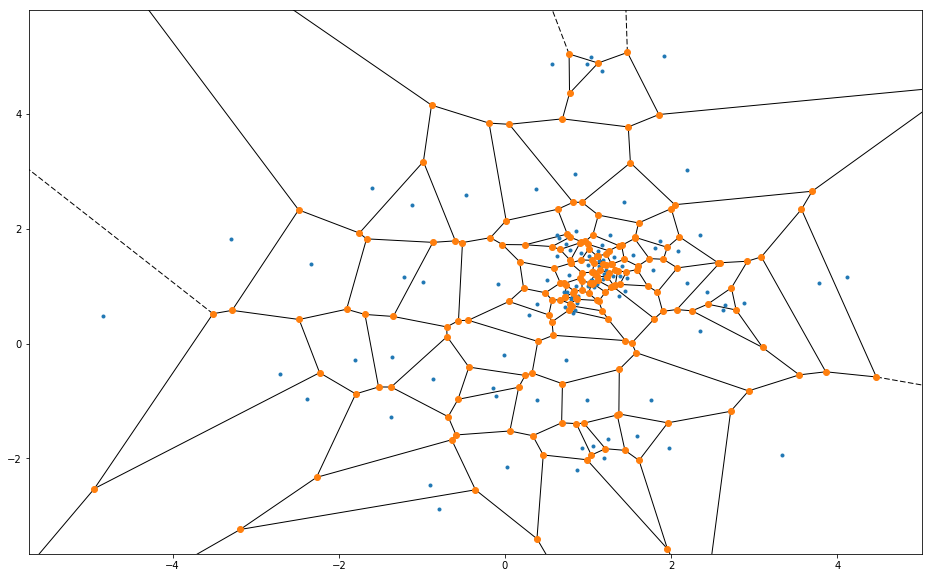

In [7]:
points = X_pca
from scipy.spatial import Voronoi, voronoi_plot_2d, voronoi_finite_polygons_2d
vor = Voronoi(points)
voronoi_plot_2d(vor)
plt.show()


In [1]:
regions, vertices = voronoi_finite_polygons_2d(vor)

topics = Topic.objects.filter(id__in=r_ind).order_by('id')

mscore = topics.order_by('-score').first().score

fig, ax = plt.subplots()

colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

for i, region in enumerate(regions):
    polygon = vertices[region]
    p = Polygon(polygon).centroid
    plt.fill(*zip(*polygon), color=colors[topics[i].primary_wg], alpha=topics[i].score*5/mscore)
    plt.plot(*zip(*polygon),color="grey")
    ti = topics[i].title
    if topics[i].share > 0.1:
        if abs(p.x) > vor.max_bound[0] + 0.1 or abs(p.y) > vor.max_bound[1] + 0.1 :
            plt.text(points[i,0],points[i,1],ti)
        else:
            plt.text(p.x,p.y,ti)
plt.plot(points[:,0], points[:,1], 'ko')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.savefig('../plots/pca_map.png',bbox_inches='tight')

plt.show()

NameError: name 'voronoi_finite_polygons_2d' is not defined

In [9]:
scores = topics.values('score') 
scores

<QuerySet [{'score': 353.176513355333}, {'score': 241.276630726252}, {'score': 355.429575979899}, {'score': 328.899499405739}, {'score': 418.82898893833}, {'score': 210.567961054092}, {'score': 265.201456212139}, {'score': 332.67996439474}, {'score': 291.994671751228}, {'score': 282.041875435876}, {'score': 261.101167951068}, {'score': 207.207198814097}, {'score': 194.205920695633}, {'score': 215.505906442981}, {'score': 321.621069864829}, {'score': 310.568657749009}, {'score': 198.343142261236}, {'score': 187.601444049634}, {'score': 213.219854616405}, {'score': 350.829337019355}, '...(remaining elements truncated)...']>

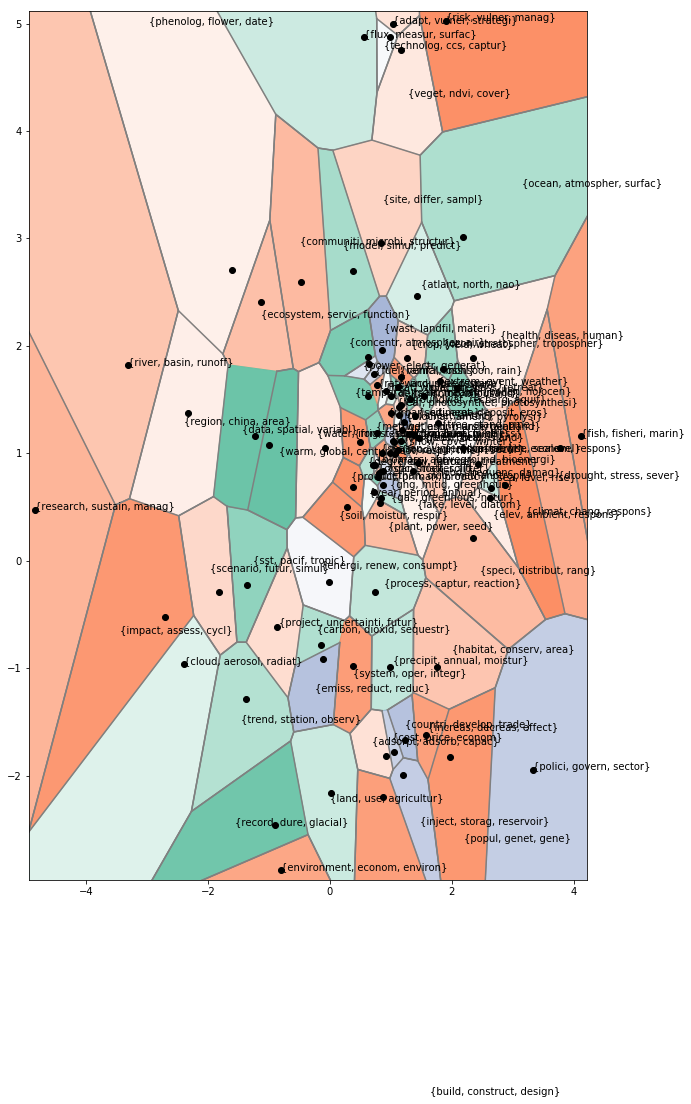

In [12]:
plt.rcParams["figure.figsize"] = [10,16]

regions, vertices = voronoi_finite_polygons_2d(vor)

topics = Topic.objects.filter(id__in=r_ind).order_by('id')

mscore = topics.order_by('-score').first().score

fig, ax = plt.subplots()

colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

for i, region in enumerate(regions):
    polygon = vertices[region]
    p = Polygon(polygon).centroid
    plt.fill(*zip(*polygon), color=colors[topics[i].primary_wg], alpha=topics[i].score*5/mscore)
    plt.plot(*zip(*polygon),color="grey")
    ti = topics[i].title
    if abs(p.x) > vor.max_bound[0] + 0.1 or abs(p.y) > vor.max_bound[1] + 0.1 :
        plt.text(points[i,0],points[i,1],ti)
    else:
        plt.text(p.x,p.y,ti)
plt.plot(points[:,0], points[:,1], 'ko')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.savefig('../plots/pca_map.png',bbox_inches='tight')

plt.show()

